# Isolas in Nonlinear Fluid Networks

*Nathaniel J. Karst and John B. Geddes*

# Preliminaries

Much of the heavy lifting of the script below is contained in the ```Network``` class, and the custom equilibrium, fold, and isola center relations defined here are simply pseudo-inherited / composite functions of primitives contained therein. In general, relations named $F_*$ are designed to find a single equilibrium, fold bifurcation, or isola center, whereas relations named $G_*$ are designed to be used in coninuation. (Note that the continuation parmater(s) used in the $G_*$ functions are theoretically arbitrary but programmatically hardcoded.)

In [1]:
import os
import pickle

import numpy as np
import scipy as sp
from scipy.optimize import fsolve

from matplotlib import pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import continuation
import network
import skeleton

In [2]:
def load_data(filename):
    f = open(f'data/{filename}.p','rb')
    tmp = pickle.load(f)
    f.close()
    return tmp

def save_data(data,filename):
    f = open(f'data/{filename}.p','wb')
    pickle.dump(data,f)
    f.close()
    
def data_exists(filename):
    return os.path.isfile(f'data/{filename}.p')

def save_fig(filename,extension='pdf'):
    plt.savefig(f'figures/{filename}.{extension}',bbox_inches='tight')

In [3]:
def get_default_params():
    p = np.zeros(len(S.v[:,0]))
    p[0] = 1
    p[1] = 1    
    
    h = np.zeros(len(S.e))
    h[0] = 0.55
    h[1] = 0.55
    
    l = np.ones(len(S.e))
    l[2] = 0.1
    l[5] = 0.2

    d = np.ones(len(S.e))
    
    return {'pPlasma':2, 'delta':np.log(10), 'pq_bcs':p,'h_bcs':h,'l':l,'d':d}

def reset_all_network_parameters():
    for key,val in get_default_params().items():
        N.set_parameter(key,val)

S = skeleton.LadderNetworkSkeleton(2)

# create construction dictionary for Network object
physParams = get_default_params()
params = {**S.get(), **physParams}
N = network.Network(params)

# reset_all_network_parameters()

[0, 0, 0, 0, 0, 0, 0, 0]


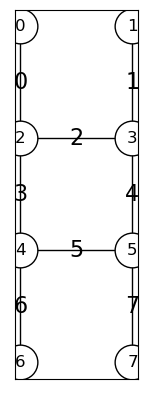

In [4]:
N.plot(annotate=True,ms=25)

# Equilibrium continuation

In this section, we track an equilibrium through $P_0/P_1$ parameter space in regime that supports up to 9 equilibria in order to identify the associated fold bifurcaitons for later continuation. 

In [5]:
def F_eq(y):
    return N.equilibrium_relation(y)

def G_eq(y):
    N.set_parameter('pq_bcs',y[-1],0)

    return N.equilibrium_relation(y[:-1])

filename = 'equilibrium_continuation'
if data_exists(filename):
    equilibrium_continuation = load_data(filename)
else:
    maxSteps = 10000
    m = -np.inf*np.ones(len(N.h) + 1)
    m[-1] = .5
    M = np.inf*np.ones(len(N.h) + 1)
    M[-1] = 1.5
    opt_eq = continuation.Options(maxSteps,m,M)

    p0_init = 0.6 # start in a regime that supports a single equilibrium
    N.set_parameter('pq_bcs',p0_init,0)

    h_init = N.find_equilibria(1) 
    y0 = np.append(N.h,p0_init)

    C = continuation.Continuer(relation=G_eq,
                 init=y0,
                 step=5e-4,
                 options=opt_eq)

    equilibrium_continuation = C.get_continuation().T
    
    save_data(equilibrium_continuation,filename)

Text(0, 0.5, '$H_5$')

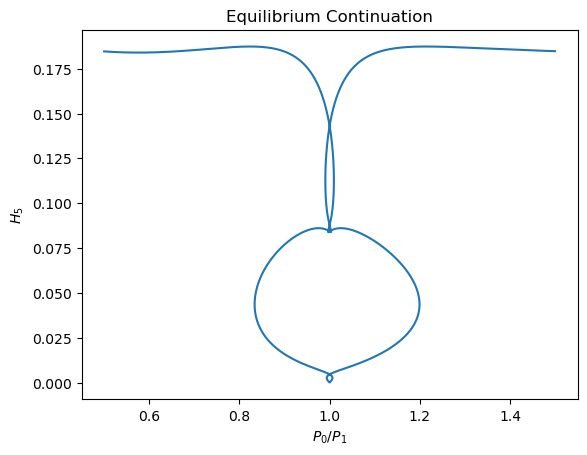

In [6]:
plt.plot(equilibrium_continuation[:,-1],equilibrium_continuation[:,5])

plt.title('Equilibrium Continuation')
plt.xlabel(r'$P_0/P_1$')
plt.ylabel(r'$H_5$')

In [7]:
# continue the main branch only for several different values of h_1;
# will separately continue the isolas later, after finding suitable starting points at the folds
H1_main_branch = [0.1,0.3,0.6]

filename = 'main_branch_continuation'
if data_exists(filename):
    main_branch_continuation = load_data(filename)
else:
    p0_init = 0.6

    maxSteps = 10000
    m = -np.inf*np.ones(len(N.h) + 1)
    m[-1] = .5
    M = np.inf*np.ones(len(N.h) + 1)
    M[-1] = 1.5
    opt_main_branch = continuation.Options(maxSteps,m,M)

    main_branch_continuation = {}
    for h1 in H1_main_branch:
        N.set_parameter('h_bcs',h1,1)
        N.set_parameter('pq_bcs',p0_init,0)

        N.find_equilibria(1)
        N.set_state(N.h)

        y0 = np.append(N.h,p0_init)

        C = continuation.Continuer(relation=G_eq,
                     init=y0,
                     step=5e-4,
                     options=opt_main_branch)

        main_branch_continuation[h1] = C.get_continuation().T
    
    save_data(main_branch_continuation,filename)

In [8]:
reset_all_network_parameters()

# Fold continuation

After refining the estimates of fold bifurcations from the equilibrium continuation above (and confirming that fold relation is correctly these points), we continue the folds through $(P_0/P_1, H_1)$ parameter space. 

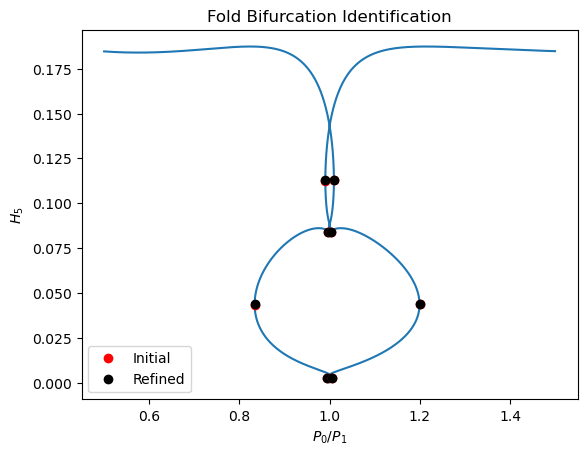

In [9]:
def F_fold(y):
    N.set_parameter('pq_bcs',y[-1],0)

    return np.append(N.equilibrium_relation(y[:-1]),N.fold_relation(y[:-1]))

dParam = np.diff(equilibrium_continuation[:,-1])
fold_candidates_idx = np.where(dParam[:-1]*dParam[1:] < 0)[0] # turning points of equilibrium curve

fold_inits = []

plt.plot(equilibrium_continuation[:,-1],equilibrium_continuation[:,5])
for i,idx in enumerate(fold_candidates_idx):
    r_label = None
    k_label = None
    if i == 0:
        r_label = 'Initial'
        k_label = 'Refined'
    
    plt.plot(equilibrium_continuation[idx,-1],equilibrium_continuation[idx,5],'ro',label=r_label)
    
    fold_refined = fsolve(F_fold,equilibrium_continuation[idx,:])    
    plt.plot(fold_refined[-1],fold_refined[5],'ko',label=k_label)
    
    fold_inits.append(fold_refined)

plt.title('Fold Bifurcation Identification')
plt.xlabel(r'$P_0/P_1$')
plt.ylabel(r'$H_5$')    
plt.legend()

In [10]:
def G_fold(y):
    N.set_parameter('pq_bcs',y[-2],0)
    N.set_parameter('h_bcs',y[-1],1)    

    return np.append(N.equilibrium_relation(y[:-2]),N.fold_relation(y[:-2]))

filename = 'fold_continuation'
if data_exists(filename):
    folds = load_data(filename)
else:
    maxSteps = 10000
    m = -np.inf*np.ones(len(N.h)+2)
    m[-2] = .5
    m[-1] = 0
    M = np.inf*np.ones(len(N.h)+2)
    M[-2] = 1.5
    M[-1] = 1
    opt_fold = continuation.Options(maxSteps,m,M)


    folds = {}
    for i,init in enumerate(fold_inits):
        y0 = np.append(init,0.55)

        C = continuation.Continuer(relation=G_fold,
                     init=y0,
                     step=5e-4,
                     options=opt_fold)

        fold_continuation = C.get_continuation().T
        folds[i] = fold_continuation
        
        save_data(folds,filename)

Text(0.5, 1.0, 'Fold Continuation')

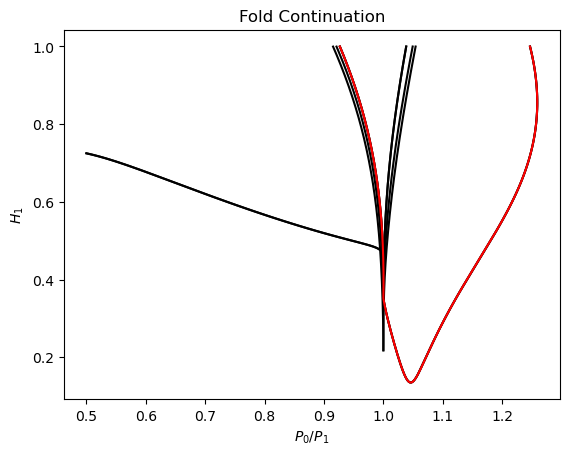

In [11]:
# regardless of whether we loaded folds from memory, or computed fresh
# identify which of the folds contains the isolas -- assumes isola branch has lowest value of h_1
h1_obs_min = np.inf
for i in folds.keys():
    fold = folds[i]
    plt.plot(fold[:,-2],fold[:,-1],'k')
    if min(fold[:,-1]) < h1_obs_min:
        h1_obs_min = min(fold[:,-1])
        fold_isola_branch = fold

plt.plot(fold_isola_branch[:,-2],fold_isola_branch[:,-1],'r')        
plt.xlabel(r'$P_0/P_1$')
plt.ylabel(r'$H_1$')
plt.title('Fold Continuation')


In [12]:
reset_all_network_parameters()

# Isola continuation

As the isolas are disconnected from the main branch, they are most easily continued starting at the fold bifurcations identified in the previous section. Note that this continuation takes place in the same space as the equilibrium continuation above.

In [13]:
H1_isola = [0.14,0.3]

filename = 'isola_continuation'
if data_exists(filename):
    isola_continuation = load_data(filename)
else:
    isola_continuation = {}
    for h1_isola in H1_isola:
        tmp = fold_isola_branch[:,-1] - h1_isola
        isola_init_idx = np.where(tmp[:-1]*tmp[1:] < 0)[0][0]
        isola_init = fold_isola_branch[isola_init_idx,:]

        N.set_parameter('h_bcs',isola_init[-1],1)
        N.set_parameter('pq_bcs',isola_init[-2],0)
        N.set_state(isola_init[:N.nVessels])

        maxSteps = 15000
        m = -np.inf*np.ones(len(N.h) + 1)
        m[-1] = .5
        M = np.inf*np.ones(len(N.h) + 1)
        M[-1] = 1.5
        opt_isola = continuation.Options(maxSteps,m,M)

        y0 = np.append(N.h,isola_init[-2])

        C = continuation.Continuer(relation=G_eq,
                     init=y0,
                     step=5e-5,
                     options=opt_isola)

        isola_continuation[h1_isola] = C.get_continuation().T
    
    save_data(isola_continuation,filename)

Text(0.5, 1.0, 'Isola Continuation')

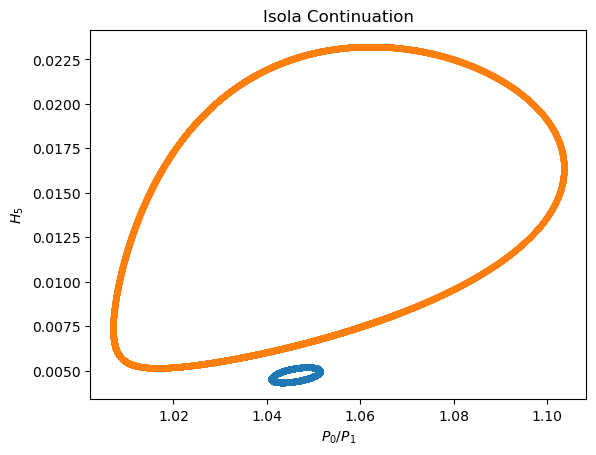

In [14]:
for h1_isola in H1_isola:
    isola = isola_continuation[h1_isola]
    plt.plot(isola[:,-1],isola[:,5],'.')
plt.xlabel(r'$P_0/P_1$')
plt.ylabel(r'$H_5$')
plt.title('Isola Continuation')

In [15]:
reset_all_network_parameters()

# Isola approximation

Here, we compute the approximation presented in Dellwo et al and compare it to the numerical continuation of the equilibria along an isola near the isola center.

In [16]:
idx = np.argmin(fold_isola_branch[:,-1])        
isola_center = fold_isola_branch[idx,:]

N.set_parameter('pq_bcs',isola_center[-2],0)
N.set_parameter('h_bcs',isola_center[-1],1)
N.set_state(isola_center[:N.nVessels])

u_0 = np.concatenate([N.p,N.q,N.h])
lambda_0 = isola_center[-2]
tau_0 = isola_center[-1]

In [17]:
J0 = N.get_jacobian_from_full_state(u_0)

test_lambda = np.zeros(J0.shape[1])
test_lambda[0] = 1.0 # hardcoded: P_0

test_tau = np.zeros(J0.shape[1])
test_tau[N.nNodes + N.nVessels + 1] = 1.0 # hardcoded: H_1

for i in range(J0.shape[0]):
    if (J0[i,:] == test_lambda).all():
        idx_lambda = i
    elif (J0[i,:] == test_tau).all():   
        idx_tau = i

# because lambda and tau are boundary conditions, these partials of F are quite simple:
# all zeros, except for a single -1 in the row associated with the b.c.
F_lambda = np.zeros(J0.shape[0])
F_lambda[idx_lambda] = -1

F_tau = np.zeros(J0.shape[0])
F_tau[idx_tau] = -1

# find an approximation of a unit vector spanning ker(J0)
L,V = sp.linalg.eig(J0)
i = np.argmin(np.abs(L))
phi = V[:,i]

# find an approximation of a unit vector spanning ker(J0^T)
L,V = sp.linalg.eig(J0.T)
i = np.argmin(np.abs(L))
psi = V[:,i]       

# find the component of -F_lambda orthogonal to ker(J0)
K = np.concatenate((J0,phi.reshape((-1,1)).T),axis=0)          
Z1 = np.linalg.lstsq(K,np.append(-F_lambda,0))[0]

H = N.get_hessian_tensor(u_0)

a = np.dot(psi,H@phi@phi)
b = np.dot(psi,H@phi@Z1)
c = np.dot(psi,H@Z1@Z1)
d = np.dot(psi,F_tau)

tau_1 = 0
tau_2 = np.sign(-a*d)

xi = []
lambda_1 = []

# make sure that the xi component has the correct sign based on quadrant
for i in range(4):
    theta = np.linspace(i*np.pi/2+0.01,(i+1)*np.pi/2-.01,50)
    if i == 0 or i == 3:
        tmp = np.sqrt(-d*tau_2/(a+2*b*np.tan(theta)+c*np.tan(theta)**2))
    else:
        tmp = -np.sqrt(-d*tau_2/(a+2*b*np.tan(theta)+c*np.tan(theta)**2))
    xi.append(tmp)
    lambda_1.append(np.tan(theta)*tmp)
    
xi = np.concatenate(xi)
lambda_1 = np.concatenate(lambda_1)

/var/folders/cg/mgkncsc906x5kznz1hwp13k00000gn/T/ipykernel_39554/3723335499.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Z1 = np.linalg.lstsq(K,np.append(-F_lambda,0))[0]


In [18]:
# values of a,b,c,d for manuscript
print([np.round(np.real(x),3) for x in [a,b,c,d]])

[-0.185, -0.045, -0.127, 0.0]


In [19]:
eps = np.sqrt(2/tau_2*(0.14 - tau_0))
eps = 0.1

u_approx = np.outer(np.ones(len(xi)),u_0) + eps*(np.outer(xi,phi) + np.outer(lambda_1,Z1))
lambda_approx = lambda_0 + eps*lambda_1

isola_approximation = np.concatenate((u_approx,lambda_approx.reshape(-1,1)),axis=1)

save_data(isola_approximation,'isola_approximation')

In [20]:
def get_Q(Y):
    Q = []
    for i in range(Y.shape[0]):
        N.set_parameter('pq_bcs',Y[i,-1],0)
        N.set_state(Y[i,:-1])
        Q.append([N.q])
    
    Q = np.concatenate(Q,axis=0)
    Q = np.concatenate([Q,Y[:,-1].reshape(-1,1)],axis=1)
    return Q

def get_P(Y):
    P= []
    for i in range(Y.shape[0]):
        N.set_parameter('pq_bcs',Y[i,-1],0)
        N.set_state(Y[i,:-1])
        P.append([N.p])
    
    P = np.concatenate(P,axis=0)
    P = np.concatenate([P,Y[:,-1].reshape(-1,1)],axis=1)
    return P

reset_all_network_parameters()
Q = get_Q(isola_continuation[.14])
P = get_P(isola_continuation[.14])

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


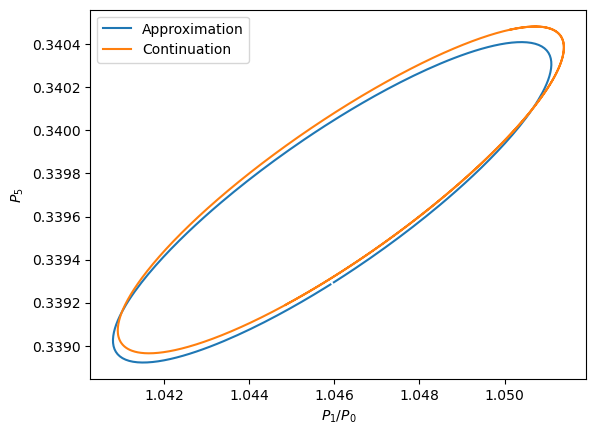

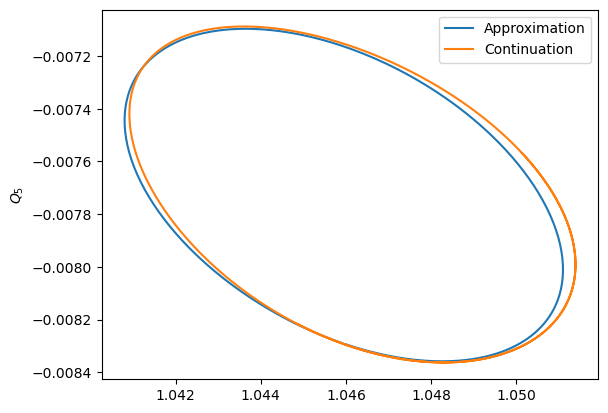

In [21]:
ves_idx = 5
plt.figure()
plt.plot(isola_approximation[:,-1],isola_approximation[:,ves_idx],label='Approximation')
plt.plot(P[:1500,-1],P[:1500,ves_idx],label='Continuation')
plt.xlabel(r'$P_1/P_0$')
plt.ylabel(r'$P_' + str(ves_idx) + '$')
plt.legend()

plt.figure()
plt.plot(isola_approximation[:,-1],isola_approximation[:,N.nNodes+ves_idx],label='Approximation')
plt.plot(Q[:1500,-1],Q[:1500,ves_idx],label='Continuation')
plt.ylabel(r'$P_' + str(ves_idx) + '$')
plt.ylabel(r'$Q_' + str(ves_idx) + '$')
plt.legend()

# Isola center continuation

We refine the estimate of the isola center identified in the previous section (and thereby confirm that the isola center relation is functioning as expected), before continuing the isola center in several different combinations of network parameters.  

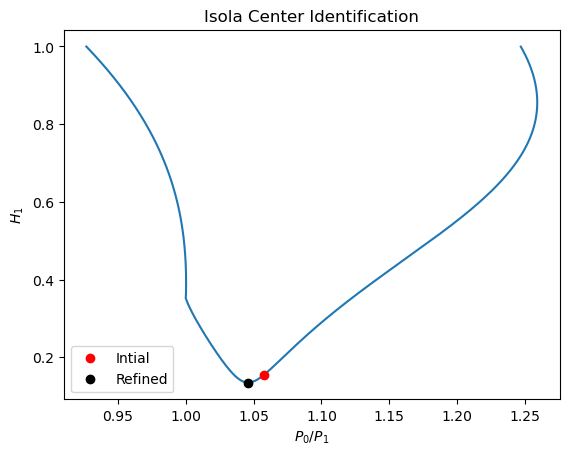

In [22]:
def F_isola_center(y):
    N.set_parameter('pq_bcs',y[-2],0)
    N.set_parameter('h_bcs',y[-1],1)    

    out = N.equilibrium_relation(y[:-2])
    out = np.append(out,N.fold_relation(y[:-2]))
    out = np.append(out,N.isola_center_relation(y[:-2]))
    
    return out

plt.plot(fold_isola_branch[:,-2],fold_isola_branch[:,-1])
idx = 3500

isola_center_init = fold_isola_branch[idx,:]
plt.plot(isola_center_init[-2],isola_center_init[-1],'ro',label='Intial')

isola_center_init = fsolve(F_isola_center,isola_center_init)
plt.plot(isola_center_init[-2],isola_center_init[-1],'ko',label='Refined')

plt.title('Isola Center Identification')
plt.xlabel(r'$P_0/P_1$')
plt.ylabel(r'$H_1$')
plt.legend()

### Fluid Properties

In [23]:
def G_isola_center(y):
    N.set_parameter('pq_bcs',y[-3],0)
    N.set_parameter('pPlasma',y[-2])    
    N.set_parameter('delta',y[-1])

    out = N.equilibrium_relation(y[:N.nVessels])
    out = np.append(out,N.fold_relation(y[:N.nVessels]))
    out = np.append(out,N.isola_center_relation(y[:N.nVessels]))
    
    return out

N.set_parameter('h_bcs',isola_center_init[-1],1)

filename = 'isola_center_continuation_pPlasma_delta'
if data_exists(filename):
    isola_center_continuation = load_data(filename)
else:
    maxSteps = 10000
    m = -np.inf*np.ones(len(N.h)+3)
    m[-3] = .5
    m[-2] = 0
    m[-1] = np.log(1)
    M = np.inf*np.ones(len(N.h)+3)
    M[-3] = 1.5
    M[-2] = 4
    M[-1] = np.log(100)

    opt_isola_center = continuation.Options(maxSteps,m,M)

    y0 = np.concatenate([isola_center_init[:N.nVessels+1],np.array([2,np.log(10)])])

    C = continuation.Continuer(relation=G_isola_center,
                 init=y0,
                 step=5e-3,
                 options=opt_isola_center)

    isola_center_continuation = C.get_continuation().T
    
    save_data(isola_center_continuation,filename)

Text(0, 0.5, '$\\delta$')

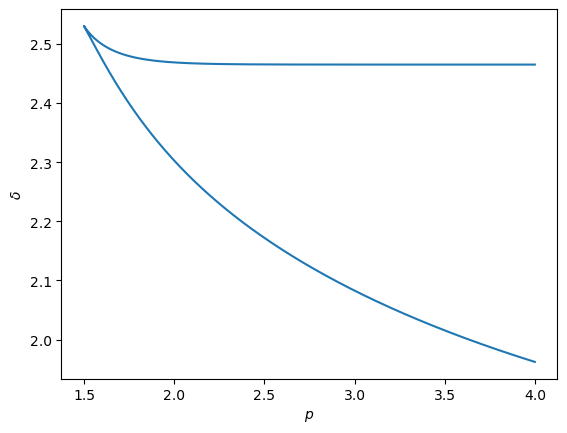

In [24]:
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1])
plt.xlabel(r'$p$')
plt.ylabel(r'$\delta$')

### Network Geometry

In [25]:
reset_all_network_parameters()

In [26]:
def G_isola_center(y):
    N.set_parameter('pq_bcs',y[-3],0)
    N.set_parameter('l',y[-2],2)    
    N.set_parameter('l',y[-1],5)

    out = N.equilibrium_relation(y[:N.nVessels])
    out = np.append(out,N.fold_relation(y[:N.nVessels]))
    out = np.append(out,N.isola_center_relation(y[:N.nVessels]))
    
    return out

N.set_parameter('pq_bcs',isola_center_init[-2],0)
N.set_parameter('h_bcs',isola_center_init[-1],1)

filename = 'isola_center_continuation_r02_r05'
if data_exists(filename):
    isola_center_continuation = load_data(filename)
else:
    maxSteps = 10000
    m = -np.inf*np.ones(len(N.h)+3)
    m[-3] = .5
    m[-2] = 0
    m[-1] = 0
    M = np.inf*np.ones(len(N.h)+3)
    M[-3] = 1.5
    M[-2] = 1
    M[-1] = 1

    opt_isola_center = continuation.Options(maxSteps,m,M)

    y0 = np.concatenate([isola_center_init[:N.nVessels+1],np.array([0.1,0.2])])

    C = continuation.Continuer(relation=G_isola_center,
                 init=y0,
                 step=5e-3,
                 options=opt_isola_center)

    isola_center_continuation = C.get_continuation().T
    
    save_data(isola_center_continuation,filename)
    
    
filename = 'isola_center_continuation_r02_r05_death'
if data_exists(filename):
    isola_center_continuation = load_data(filename)
else:
    maxSteps = 10000
    m = -np.inf*np.ones(len(N.h)+3)
    m[-3] = .25
    m[-2] = 0
    m[-1] = 0
    M = np.inf*np.ones(len(N.h)+3)
    M[-3] = 4
    M[-2] = 1
    M[-1] = 1

    def F_isola_sanity(y):
        N.set_parameter('pq_bcs',y[-2],0)
        N.set_parameter('l',y[-1],2)    
    
        out = N.equilibrium_relation(y[:N.nVessels])
        out = np.append(out,N.fold_relation(y[:N.nVessels]))
        out = np.append(out,N.isola_center_relation(y[:N.nVessels]))
        
        return out
    
    np.random.seed(1234)
    for i in range(1000):
        reset_all_network_parameters()
        N.set_parameter('h_bcs',isola_center_init[-1],1)
        
        r20_new = 10*np.random.random()
        # print(r20_new)
        tmp = fsolve(F_isola_sanity,np.concatenate([isola_center_init[:N.nVessels+1],np.array([r20_new])]))
    
        if np.linalg.norm(F_isola_sanity(tmp)) < 1e-6:
            if np.abs(tmp[-1] - 0.1) > 1e-2:
                if tmp[-1] > 1e-3:
                    print(tmp)
                    break
    
    opt_isola_center = continuation.Options(maxSteps,m,M)

    y0 = np.concatenate([tmp[:N.nVessels+1],np.array([tmp[-1],0.2])])

    C = continuation.Continuer(relation=G_isola_center,
                 init=y0,
                 step=5e-3,
                 options=opt_isola_center)

    isola_center_continuation = C.get_continuation().T
    
    save_data(isola_center_continuation,filename)    

(0.0, 0.65)

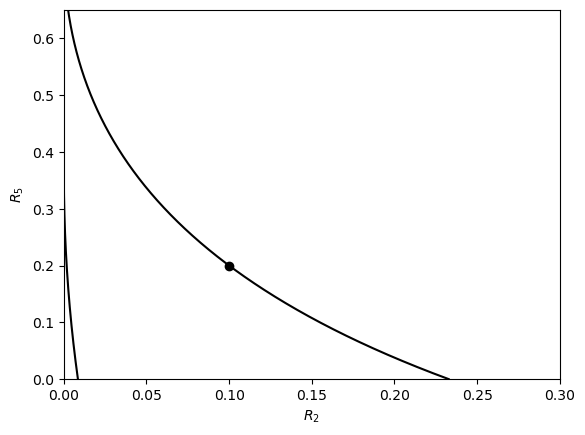

In [27]:
filename = 'isola_center_continuation_r02_r05'
isola_center_continuation = load_data(filename)
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k')

filename = 'isola_center_continuation_r02_r05_death'
isola_center_continuation = load_data(filename)
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k')

plt.xlabel(r'$R_2$')
plt.ylabel(r'$R_5$')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot(0.1,0.2,'ko')

plt.xlim((0,0.3))
plt.ylim((0,0.65))

### Boundary Conditions

In [28]:
reset_all_network_parameters()

In [29]:
def G_isola_center(y):
    N.set_parameter('pq_bcs',y[-3],0)
    N.set_parameter('h_bcs',y[-2],0)    
    N.set_parameter('h_bcs',y[-1],1)

    out = N.equilibrium_relation(y[:N.nVessels])
    out = np.append(out,N.fold_relation(y[:N.nVessels]))
    out = np.append(out,N.isola_center_relation(y[:N.nVessels]))
    
    return out

N.set_parameter('pq_bcs',isola_center_init[-2],0)
N.set_parameter('h_bcs',isola_center_init[-1],1)

filename = 'isola_center_continuation_h0_h1'
if data_exists(filename):
    isola_center_continuation = load_data(filename)
else:
    maxSteps = 10000
    m = -np.inf*np.ones(len(N.h)+3)
    m[-3] = .5
    m[-2] = 0
    m[-1] = 0
    M = np.inf*np.ones(len(N.h)+3)
    M[-3] = 1.5
    M[-2] = 1
    M[-1] = 1

    opt_isola_center = continuation.Options(maxSteps,m,M)

    y0 = np.concatenate([isola_center_init[:N.nVessels+1],np.array([0.55,isola_center_init[-1]])])

    C = continuation.Continuer(relation=G_isola_center,
                 init=y0,
                 step=5e-3,
                 options=opt_isola_center)

    isola_center_continuation = C.get_continuation().T
    
    save_data(isola_center_continuation,filename)

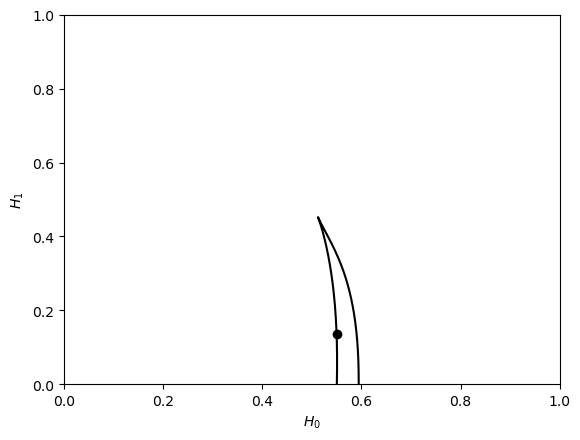

In [30]:
filename = 'isola_center_continuation_h0_h1'
isola_center_continuation = load_data(filename)

plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k')
plt.xlabel(r'$H_0$')
plt.ylabel(r'$H_1$')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot(0.55,isola_center_init[-1],'ko')

# Secondary continuations

### Fluid Properties

In [31]:
reset_all_network_parameters()

In [32]:
def G_isola_center(y):
    N.set_parameter('pq_bcs',y[-3],0)
    N.set_parameter('h_bcs',y[-2],0)    
    N.set_parameter('h_bcs',y[-1],1)

    out = N.equilibrium_relation(y[:N.nVessels])
    out = np.append(out,N.fold_relation(y[:N.nVessels]))
    out = np.append(out,N.isola_center_relation(y[:N.nVessels]))
    
    return out

filename = 'isola_center_continuation_h0_h1_p_4'
if data_exists(filename):
    isola_center_continuation = load_data(filename)
else:
    secondary_init = load_data('isola_center_continuation_pPlasma_delta')
    N.set_state(secondary_init[0,:8])
    N.set_parameter('pq_bcs',secondary_init[0,-3],0)
    N.set_parameter('pPlasma',secondary_init[0,-2])
    N.set_parameter('delta',secondary_init[0,-1])    
    
    
    maxSteps = 10000
    m = -np.inf*np.ones(len(N.h)+3)
    m[-3] = .5
    m[-2] = 0
    m[-1] = 0
    M = np.inf*np.ones(len(N.h)+3)
    M[-3] = 1.5
    M[-2] = 1
    M[-1] = 1

    opt_isola_center = continuation.Options(maxSteps,m,M)

    y0 = np.concatenate([secondary_init[0,:N.nVessels+1],np.array([0.55,isola_center_init[-1]])])

    C = continuation.Continuer(relation=G_isola_center,
                 init=y0,
                 step=5e-3,
                 options=opt_isola_center)

    isola_center_continuation = C.get_continuation().T
    
    save_data(isola_center_continuation,filename)

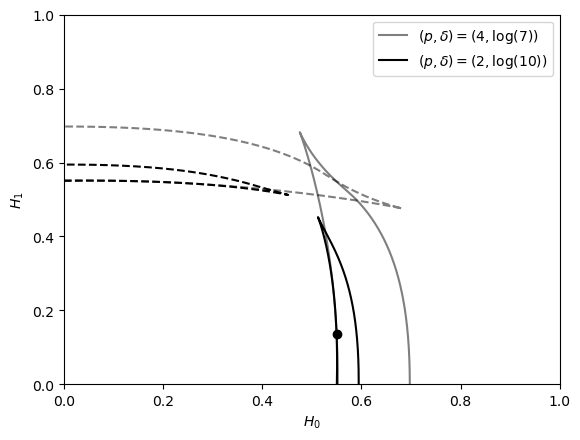

In [33]:
filename = 'isola_center_continuation_h0_h1_p_4'
isola_center_continuation = load_data(filename)
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k',alpha=0.5,label='$(p,\delta) = (4,\log(7))$')
plt.plot(isola_center_continuation[:,-1],isola_center_continuation[:,-2],'k--',alpha=0.5)
plt.xlabel(r'$H_0^2$')
plt.ylabel(r'$H_1^5$')
plt.xlim((0,1))
plt.ylim((0,1))

filename = 'isola_center_continuation_h0_h1'
isola_center_continuation = load_data(filename)
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k',label='$(p,\delta) = (2,\log(10))$')
plt.plot(isola_center_continuation[:,-1],isola_center_continuation[:,-2],'k--')
plt.xlabel(r'$H_0$')
plt.ylabel(r'$H_1$')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot(0.55,isola_center_init[-1],'ko')

plt.legend()

### Network Geometry

In [34]:
reset_all_network_parameters()

In [35]:
def G_isola_center(y):
    N.set_parameter('pq_bcs',y[-3],0)
    N.set_parameter('h_bcs',y[-2],0)    
    N.set_parameter('h_bcs',y[-1],1)

    out = N.equilibrium_relation(y[:N.nVessels])
    out = np.append(out,N.fold_relation(y[:N.nVessels]))
    out = np.append(out,N.isola_center_relation(y[:N.nVessels]))
    
    return out

filename = 'isola_center_continuation_h0_h1_low_r20'
if data_exists(filename):
    isola_center_continuation = load_data(filename)
else:
    secondary_init = load_data('isola_center_continuation_r02_r05')
    thresh = 0.01
    tmp = secondary_init[:,-2]-thresh
    idx = np.where(tmp[:1]*tmp[:-1] < 0)[0][0]  
    print(secondary_init[idx,-2])
    print(secondary_init[idx,-1])
    
    N.set_state(secondary_init[idx,:8])
    N.set_parameter('pq_bcs',secondary_init[idx,-3],0)
    N.set_parameter('l',secondary_init[idx,-2],2)
    N.set_parameter('l',secondary_init[idx,-1],5)    
    
    
    maxSteps = 10000
    m = -np.inf*np.ones(len(N.h)+3)
    m[-3] = .5
    m[-2] = 0
    m[-1] = 0
    M = np.inf*np.ones(len(N.h)+3)
    M[-3] = 1.5
    M[-2] = 1
    M[-1] = 1

    opt_isola_center = continuation.Options(maxSteps,m,M)

    y0 = np.concatenate([secondary_init[idx,:N.nVessels+1],np.array([0.55,isola_center_init[-1]])])

    C = continuation.Continuer(relation=G_isola_center,
                 init=y0,
                 step=1e-2,
                 options=opt_isola_center)

    isola_center_continuation = C.get_continuation().T
    
    save_data(isola_center_continuation,filename)

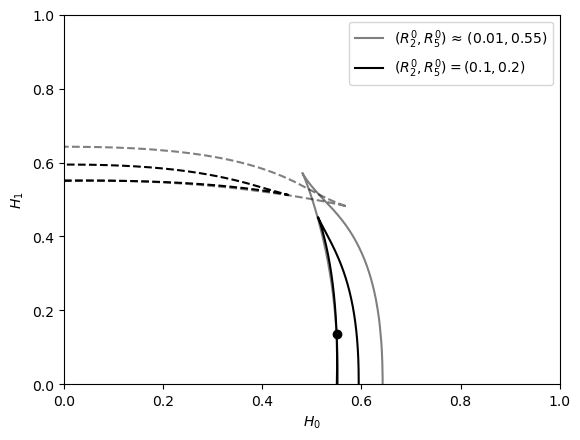

In [36]:
filename = 'isola_center_continuation_h0_h1_low_r20'
isola_center_continuation = load_data(filename)
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k',alpha=0.5,label='$(R_2^0,R_5^0)~≈~(0.01,0.55)$')
plt.plot(isola_center_continuation[:,-1],isola_center_continuation[:,-2],'k--',alpha=0.5)
plt.xlabel(r'$H_0^2$')
plt.ylabel(r'$H_1^5$')
plt.xlim((0,1))
plt.ylim((0,1))

filename = 'isola_center_continuation_h0_h1'
isola_center_continuation = load_data(filename)
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k',label='$(R_2^0,R_5^0) = (0.1,0.2)$')
plt.plot(isola_center_continuation[:,-1],isola_center_continuation[:,-2],'k--')
plt.xlabel(r'$H_0$')
plt.ylabel(r'$H_1$')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot(0.55,isola_center_init[-1],'ko')

plt.legend()

In [37]:
reset_all_network_parameters()

In [38]:
def G_isola_center(y):
    N.set_parameter('pq_bcs',y[-3],0)
    N.set_parameter('h_bcs',y[-2],0)    
    N.set_parameter('h_bcs',y[-1],1)

    out = N.equilibrium_relation(y[:N.nVessels])
    out = np.append(out,N.fold_relation(y[:N.nVessels]))
    out = np.append(out,N.isola_center_relation(y[:N.nVessels]))
    
    return out

filename = 'isola_center_continuation_h0_h1_low_r50'
if data_exists(filename):
    isola_center_continuation = load_data(filename)
else:
    secondary_init = load_data('isola_center_continuation_r02_r05')
    thresh = 0.01
    tmp = secondary_init[:,-1]-thresh
    idx = np.where(tmp[:1]*tmp[:-1] < 0)[0][0]    
    
    N.set_state(secondary_init[idx,:8])
    N.set_parameter('pq_bcs',secondary_init[idx,-3],0)
    N.set_parameter('l',secondary_init[idx,-2],2)
    N.set_parameter('l',secondary_init[idx,-1],5)    
    
    
    maxSteps = 10000
    m = -np.inf*np.ones(len(N.h)+3)
    m[-3] = .5
    m[-2] = 0
    m[-1] = 0
    M = np.inf*np.ones(len(N.h)+3)
    M[-3] = 1.5
    M[-2] = 1
    M[-1] = 1

    opt_isola_center = continuation.Options(maxSteps,m,M)

    y0 = np.concatenate([secondary_init[idx,:N.nVessels+1],np.array([0.55,isola_center_init[-1]])])
    
    
    C = continuation.Continuer(relation=G_isola_center,
                 init=y0,
                 step=5e-3,
                 options=opt_isola_center)

    isola_center_continuation = C.get_continuation().T
    
    save_data(isola_center_continuation,filename)

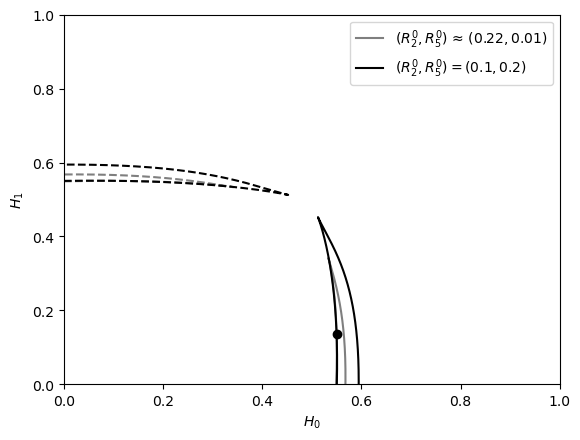

In [39]:
filename = 'isola_center_continuation_h0_h1_low_r50'
isola_center_continuation = load_data(filename)
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k',alpha=0.5,label='$(R_2^0,R_5^0)~≈~(0.22,0.01)$')
plt.plot(isola_center_continuation[:,-1],isola_center_continuation[:,-2],'k--',alpha=0.5)
plt.xlabel(r'$H_0^2$')
plt.ylabel(r'$H_1^5$')
plt.xlim((0,1))
plt.ylim((0,1))

filename = 'isola_center_continuation_h0_h1'
isola_center_continuation = load_data(filename)
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k',label='$(R_2^0,R_5^0) = (0.1,0.2)$')
plt.plot(isola_center_continuation[:,-1],isola_center_continuation[:,-2],'k--')
plt.xlabel(r'$H_0$')
plt.ylabel(r'$H_1$')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot(0.55,isola_center_init[-1],'ko')

plt.legend()

## Collision of Isolas

In [40]:
reset_all_network_parameters()

In [41]:
filename = 'isola_continuation_merge'
if data_exists(filename):
    isola_continuation_merge = load_data(filename)
    main_continuation_merge = load_data('_'.join(['main'] + filename.split('_')[1:]))
    other_continuation_merge = load_data('_'.join(['other'] + filename.split('_')[1:]))
elif data_exists('isola_continuation'):    
    isola_continuation = load_data('isola_continuation')
    
    isola_continuation = isola_continuation[0.14]
    N.set_parameter('h_bcs',.14,1)
    
    R20 = np.logspace(-1,-3,50)
    
    spine = {}
    
    init = fsolve(F_fold,isola_continuation[3800,:])
    res = np.linalg.norm(F_fold(init))

    print('Computing spine...')
    for i,r20 in enumerate(R20):
        N.set_parameter('l',r20,2)
        init = fsolve(F_fold,init)
        res = np.linalg.norm(F_fold(init))
        # print(res)
        spine[r20] = init    

    
    m = -np.inf*np.ones(len(N.h) + 1)
    m[-1] = 1/3.0
    M = np.inf*np.ones(len(N.h) + 1)
    M[-1] = 5
    opt_isola = continuation.Options(40000,m,M)
    opt_main = continuation.Options(10000,m,M)
    opt_other = continuation.Options(80000,m,M)
    
    isola_continuation_merge = {}
    main_continuation_merge = {}
    other_continuation_merge = {}

    selections = []
    for r20 in [0.001, 0.01, 0.021]:
        selections.append(np.where(R20 <= r20)[0][0])
    
    for r20 in R20[[selections]]:
        print(r20)
        # continuation of isola
        print('Continuing isola...')
        isola_init = spine[r20]
        N.set_parameter('pq_bcs',isola_init[-1],0)
        N.set_state(isola_init[:N.nVessels])
        N.set_parameter('l',r20,2)
    
        y0 = np.append(N.h,isola_init[-1])
        C = continuation.Continuer(relation=G_eq,
                     init=y0,
                     step=1e-4,
                     options=opt_isola)
        isola_continuation_merge[r20] = C.get_continuation().T
    
        # continuation of main branch
        print('Continuing main branch...')        
        N.set_parameter('pq_bcs',0.6,0)    
        N.find_equilibria(1) 
        y0 = np.append(N.h,0.6)
        
        C = continuation.Continuer(relation=G_eq,
             init=y0,
             step=5e-4,
             options=opt_main)
        
        main_continuation_merge[r20] = C.get_continuation().T
    
        # continuation of other branch
        print('Continuing other branch...')        
        N.set_parameter('pq_bcs',2.5,0)    
        while True:
            N.find_equilibria(1) 
            if N.q[5] < 0:
                break
        y0 = np.append(N.h,2.5)
    
        C = continuation.Continuer(relation=G_eq,
             init=y0,
             step=1e-4,
             options=opt_other)
        
        other_continuation_merge[r20] = C.get_continuation().T
        
#         if i >= start + num - 1:
#             break

#         i += 1

    save_data(isola_continuation_merge,'isola_continuation_merge')
    save_data(main_continuation_merge,'main_continuation_merge')    
    save_data(other_continuation_merge,'other_continuation_merge')

(-0.035, 0.035)

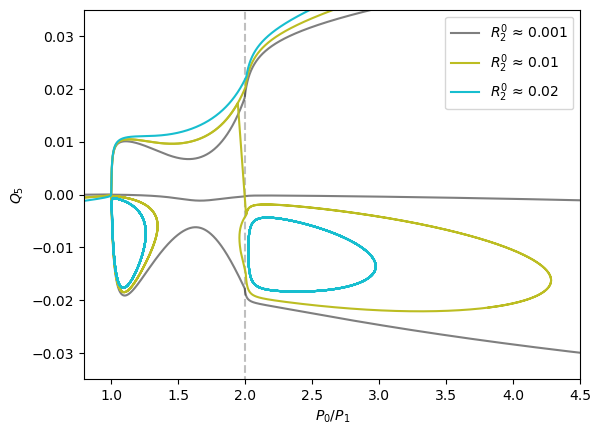

In [42]:
idx0 = -1
idx1 = 5

c = colors
a = [1,1]

for i, r20 in enumerate(main_continuation_merge.keys()):
    N.set_parameter('l',r20,2)
    for j,data in enumerate([main_continuation_merge[r20], other_continuation_merge[r20], isola_continuation_merge[r20]]):
        if i == 1 and j > 0:
            data = data[40000:,:]
        data = get_Q(data)
        label = None
        if j == 0:
            label = r'$R_2^0$' + ' ≈ ' + str(np.round(r20,3))

        if r20 < 0.0018 and j > 1:
            continue

        z = 1
        a = 1
        if r20 < 0.0018:
            z = -1
            a = 1
        plt.plot(data[:,idx0],data[:,idx1],c=c[i+7],alpha=a,label=label,zorder=z)

plt.plot([2,2],[-0.04,0.04],'k--',alpha=0.25,zorder=-1)

plt.legend()
plt.xlabel(r'$P_0/P_1$')
plt.ylabel(r'$Q_' + str(idx1) + '$')

plt.xlim((0.8,4.5))
plt.ylim((-0.035,0.035))

# Heat Map

Here, we find the area of $(H_0,H_1)$ plane supporting isolas at a grid in $(R_2^0, R_5^0)$ space and a grid in $(p,\delta)$ space. NB: These are fairly time-intensive. 

## Nominal Resistance Space

In [43]:
reset_all_network_parameters()

In [44]:
def get_area(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def F_isola_center_heat_map(y):
    N.set_parameter('pq_bcs',y[-2],0)
    N.set_parameter('h_bcs',y[-1],0)    

    out = N.equilibrium_relation(y[:-2])
    out = np.append(out,N.fold_relation(y[:-2]))
    out = np.append(out,N.isola_center_relation(y[:-2]))
    
    return out

def G_isola_center(y):
    N.set_parameter('pq_bcs',y[-3],0)
    N.set_parameter('h_bcs',y[-2],0)    
    N.set_parameter('h_bcs',y[-1],1)

    out = N.equilibrium_relation(y[:N.nVessels])
    out = np.append(out,N.fold_relation(y[:N.nVessels]))
    out = np.append(out,N.isola_center_relation(y[:N.nVessels]))
    
    return out

maxSteps = 10000
m = -np.inf*np.ones(len(N.h)+3)
m[-3] = .5
m[-2] = 0
m[-1] = 0
M = np.inf*np.ones(len(N.h)+3)
M[-3] = 1.5
M[-2] = 1
M[-1] = 1

opt_isola_center = continuation.Options(maxSteps,m,M)

In [45]:
filename = 'heat_map_r20_r50'
if data_exists(filename):
    heat_map_output = load_data(filename)
    R20 = heat_map_output['R20']
    R50 = heat_map_output['R50']
    heat_map_continuations = heat_map_output['continuation']
    heat_map_area = heat_map_output['area']
    heat_map_coexist = heat_map_output['coexist']
else:
    isola_center_continuation = load_data('isola_center_continuation_h0_h1')
    init = isola_center_continuation[10,:-1]
    N.set_parameter('h_bcs',isola_center_continuation[10,-1],1)
    
    heat_map_inits = {}

    step = 0.05
    start = N.l[2]
    R20 = [start + step*i for i in range(9)]

    start = N.l[5]
    R50 = [start + step*i for i in range(37)]    

    np.set_printoptions(suppress = True)
    z0 = init.copy()
    for i,r20 in enumerate(R20):
        N.l[2] = r20
        z0 = fsolve(F_isola_center_heat_map,z0)
        heat_map_inits[(i,0)] = z0


    for i,r20 in enumerate(R20):    
        for j,r50 in enumerate(R50):
            if j == 0:
                continue    
            N.l[2] = r20  
            N.l[5] = r50
            z0 = heat_map_inits[(i,j-1)]
            z0 = fsolve(F_isola_center_heat_map,z0)
            heat_map_inits[(i,j)] = z0
    #         print(np.linalg.norm(F_isola_center_heat_map(z0)))

    heat_map_continuations = {}
    heat_map_coexist = {}
    heat_map_area = {}
    count = 0
    for key,init in heat_map_inits.items():
        count += 1
        print(f'{np.round((count-1)/len(heat_map_inits)*100,2)}% complete...')
        print(f'Working on ({key[0]},{key[1]}) <-> (R_2^0,R_5^0) = ({R20[key[0]]},{R50[key[1]]})')        

        N.l[2] = R20[key[0]]
        N.l[5] = R50[key[1]]

        y0 = np.append(init,init[1])

        C = continuation.Continuer(relation=G_isola_center,
                     init=y0,
                     step=5e-3,
                     options=opt_isola_center)

        try:
            isola_center_continuation = C.get_continuation().T

            x = isola_center_continuation[:,-2]
            y = isola_center_continuation[:,-1]

            A = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
            coexist = (np.max(y/x) > 1)*1.0

            heat_map_continuations[key] = isola_center_continuation
            heat_map_coexist[key] = coexist
            heat_map_area[key] = A
        except:
            print('fail')
            heat_map_continuations[key] = []
            heat_map_coexist[key] = 0
            heat_map_area[key] = 0    
            
    heat_map_output = {}

    heat_map_output['R20'] = R20
    heat_map_output['R50'] = R50
    heat_map_output['continuation'] = heat_map_continuations
    heat_map_output['area'] = heat_map_area
    heat_map_output['coexist'] = heat_map_coexist

    save_data(heat_map_output,'heat_map_r20_r50')            

Text(50.722222222222214, 0.5, '$R_5^0$')

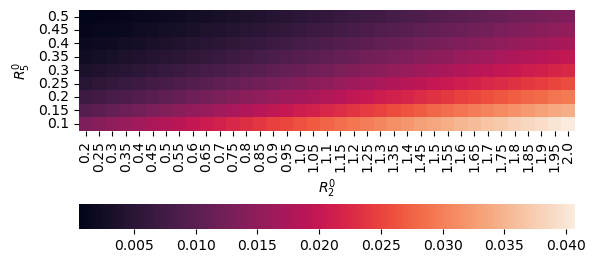

In [46]:
import seaborn as sns

A = np.zeros((len(R20),len(R50)))
X = np.zeros((len(R20),len(R50)))
for i,r50 in enumerate(R20):
    for j,r20 in enumerate(R50):
        A[i,j] = heat_map_area[(i,j)]
        X[i,j] = heat_map_coexist[(i,j)]     

ax = sns.heatmap(A,yticklabels=np.round(R20,2),xticklabels=np.round(R50,2),
                 square=True,cbar_kws={"orientation": "horizontal",'pad':0.2})
ax.invert_yaxis()
plt.xlabel(r'$R_2^0$')
plt.ylabel(r'$R_5^0$')
# plt.title(r'Percent of $(H_0,H_1)$ Plane Supporting Isolas')

## Fluid Space

In [47]:
reset_all_network_parameters()

In [48]:
filename = 'heat_map_p_delta'
if data_exists(filename):
    heat_map_output = load_data(filename)
    P = heat_map_output['P']
    Delta = heat_map_output['Delta']
    heat_map_continuations = heat_map_output['continuation']
    heat_map_area = heat_map_output['area']
    heat_map_coexist = heat_map_output['coexist']
    heat_map_inits = heat_map_output['inits']
else:
    isola_center_continuation = load_data('isola_center_continuation_h0_h1')
    init = isola_center_continuation[20,:-1]
    N.set_parameter('h_bcs',isola_center_continuation[10,-1],1)
    
    heat_map_inits = {}
    
    start = 2
    stop = 4
    steps = 20
    
    step = (stop - start)/steps
    P = [start + step*i for i in range(steps+1)]
    
    start = np.log(10)
    stop = np.log(50)
    steps = 21
    step = (stop - start)/steps
    step = 0.05
    DeltaUp = [start + step*i for i in range(steps+1)]    
    DeltaDown = [start - step*i for i in range(1,10)]
    Delta = DeltaDown[::-1] + DeltaUp
    
    np.set_printoptions(suppress = True)
    z0 = init.copy()
    print('Computing spine...')
    for i,p in enumerate(P):
        N.pPlasma = p
        z0 = fsolve(F_isola_center_heat_map,z0)
        if np.min(z0[:N.nVessels]) < 0 or np.max(z0[:N.nVessels]) > 1:
            print('PROBLEM!')
            print(i,z0)
            print()
                  
        heat_map_inits[(i,len(DeltaDown))] = z0
    
    print('Computing remaining initial conditions...')
    for j,delta in enumerate(DeltaUp):
        if j == 0:
            continue
        j += len(DeltaDown)
        for i,p in enumerate(P):    
            N.pPlasma = p  
            N.delta = delta
            
            z0 = heat_map_inits[(i,j-1)]
            z0 = fsolve(F_isola_center_heat_map,z0)
            heat_map_inits[(i,j)] = z0
            if np.min(z0[:N.nVessels]) < 0 or np.max(z0[:N.nVessels]) > 1:
                print('PROBLEM!')
                print(i,j,z0)            
                print()          
    
    for j,delta in enumerate(DeltaDown):       
        for i,p in enumerate(P):    
            N.pPlasma = p  
            N.delta = delta
            
            z0 = heat_map_inits[(i,len(DeltaDown)-j)]
            z0 = fsolve(F_isola_center_heat_map,z0)
            heat_map_inits[(i,len(DeltaDown)-j-1)] = z0
            if np.min(z0[:N.nVessels]) < 0 or np.max(z0[:N.nVessels]) > 1:
                print('PROBLEM!')
                print(i,j,z0)            
                print()             


    heat_map_continuations = {}
    heat_map_coexist = {}
    heat_map_area = {}
    count = 0
    
    for key,init in heat_map_inits.items():
        count += 1
        print(f'{np.round((count-1)/len(heat_map_inits)*100,2)}% complete...')
        print(f'Working on ({key[0]},{key[1]}) <-> (p,delta) = ({P[key[0]]},{Delta[key[1]]})')
        N.pPlasma = P[key[0]]
        N.delta = Delta[key[1]]

        y0 = np.append(init,init[1])

        C = continuation.Continuer(relation=G_isola_center,
                     init=y0,
                     step=1e-2,
                     options=opt_isola_center)
        try:
            isola_center_continuation = C.get_continuation().T

            x = isola_center_continuation[:,-2]
            y = isola_center_continuation[:,-1]

            A = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
            coexist = (np.max(y/x) > 1)*1.0

            heat_map_continuations[key] = isola_center_continuation
            heat_map_coexist[key] = coexist
            heat_map_area[key] = A
        except:
            print(f'Failure at (i,j) = ({key[0]},{key[1]}) <-> (p,delta) = ({P[key[0]]},{Delta[key[1]]})')
            heat_map_continuations[key] = []
            heat_map_coexist[key] = np.nan
            heat_map_area[key] = np.nan    
            
    heat_map_output = {}

    heat_map_output['P'] = P
    heat_map_output['Delta'] = Delta
    heat_map_output['continuation'] = heat_map_continuations
    heat_map_output['area'] = heat_map_area
    heat_map_output['coexist'] = heat_map_coexist
    heat_map_output['inits'] = heat_map_inits    

    save_data(heat_map_output,'heat_map_p_delta')            

Text(0.5, 1.0, 'Percent of $(H_0,H_1)$ Plane Supporting Isolas')

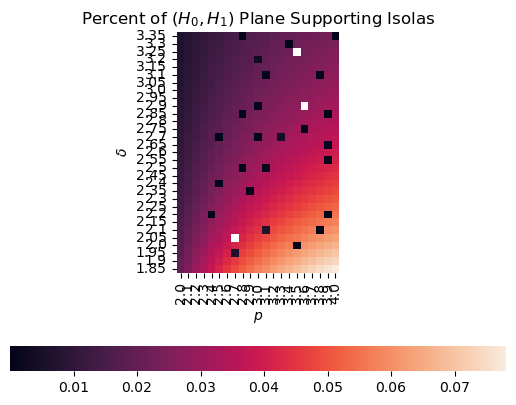

In [49]:
import seaborn as sns

A = np.zeros((len(P),len(Delta)))
X = np.zeros((len(P),len(Delta)))
for i,p in enumerate(P):
    for j,delta in enumerate(Delta):
        A[i,j] = heat_map_area[(i,j)]
        X[i,j] = heat_map_coexist[(i,j)]     

ax = sns.heatmap(A.T,xticklabels=np.round(P,2),yticklabels=np.round(Delta,2),
                 square=True,cbar_kws={"orientation": "horizontal",'pad':0.2})
ax.invert_yaxis()
plt.xlabel(r'$p$')
plt.ylabel(r'$\delta$')
plt.title(r'Percent of $(H_0,H_1)$ Plane Supporting Isolas')

### Corrections

A small number of the $(p,\delta)$ continuations above fail; here we re-run these with differing step sizes to get past tough spots.

Text(0.5, 1.0, 'Percent of $(H_0,H_1)$ Plane Supporting Isolas')

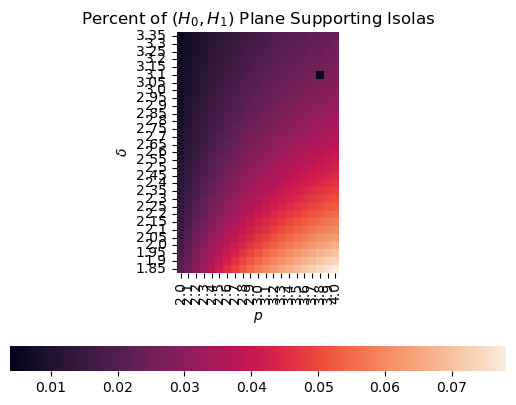

In [50]:
filename = 'heat_map_p_delta_corrected'
if data_exists(filename):
    heat_map_output = load_data(filename)
    P = heat_map_output['P']
    Delta = heat_map_output['Delta']
    heat_map_continuations = heat_map_output['continuation']
    heat_map_area = heat_map_output['area']
    heat_map_coexist = heat_map_output['coexist']
    heat_map_inits = heat_map_output['inits']
else:
    heat_map_output = load_data('heat_map_p_delta')
    
    P = heat_map_output['P']
    Delta = heat_map_output['Delta']
    heat_map_continuations = heat_map_output['continuation']
    heat_map_area = heat_map_output['area']
    heat_map_coexist = heat_map_output['coexist']
    heat_map_inits = heat_map_output['inits']
    
    A = np.zeros((len(P),len(Delta)))
    X = np.zeros((len(P),len(Delta)))
    for i,p in enumerate(P):
        for j,delta in enumerate(Delta):
            A[i,j] = heat_map_area[(i,j)]    

    reset_all_network_parameters()

    # In some cases, the continuer fails entirely. Here, we try again with a smaller step. 
    I,J = np.where(np.isnan(A))
    for idx, i in enumerate(I):
        print(f'{np.round((idx)/len(I)*100,2)}% complete...')
        print(f'Working on {i,j} <-> (p,delta) = ({P[i]},{Delta[j]})')        
        j = J[idx]
        
        N.pPlasma = P[i]
        N.delta = Delta[j]
    
        init = heat_map_inits[(i,j)]
        y0 = np.append(init,init[1])
    
        C = continuation.Continuer(relation=G_isola_center,
                     init=y0,
                     step=1e-3,
                     options=opt_isola_center)
        
        isola_center_continuation = C.get_continuation().T
    
        x = isola_center_continuation[:,-2]
        y = isola_center_continuation[:,-1]
    
        A = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
        coexist = (np.max(y/x) > 1)*1.0  
        
        heat_map_continuations[(i,j)] = isola_center_continuation
        heat_map_coexist[(i,j)] = coexist
        heat_map_area[(i,j)] = A   

        
    A = np.zeros((len(P),len(Delta)))
    X = np.zeros((len(P),len(Delta)))
    for i,p in enumerate(P):
        for j,delta in enumerate(Delta):
            A[i,j] = heat_map_area[(i,j)]    
        
        
    # In some cases, the continuer gets turned around and doubles back on itself, 
    # resulting an an "area between the curves" that is approximately zero. Here, we fix these.
    reset_all_network_parameters()
    I,J = np.where(A < 5e-3)
    for idx, i in enumerate(I):
        print(f'{np.round((idx)/len(I)*100,2)}% complete...')
        print(f'Working on {i,j} <-> (p,delta) = ({P[i]},{Delta[j]})')
        j = J[idx]
        
        N.pPlasma = P[i]
        N.delta = Delta[j]
    
        init = heat_map_inits[(i,j)]
        y0 = np.append(init,init[1])
    
        C = continuation.Continuer(relation=G_isola_center,
                     init=y0,
                     step=1e-3,
                     options=opt_isola_center)
        
        try: 
            isola_center_continuation = C.get_continuation().T
    
            x = isola_center_continuation[:,-2]
            y = isola_center_continuation[:,-1]
    
            A = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
            coexist = (np.max(y/x) > 1)*1.0  
    
            heat_map_continuations[(i,j)] = isola_center_continuation
            heat_map_coexist[(i,j)] = coexist
            heat_map_area[(i,j)] = A
        except:
            continue
            
    A = np.zeros((len(P),len(Delta)))
    X = np.zeros((len(P),len(Delta)))
    for i,p in enumerate(P):
        for j,delta in enumerate(Delta):
            A[i,j] = heat_map_area[(i,j)]                

    # In some cases, a slightly larger step is necessary to get us past difficult turning points.
    reset_all_network_parameters()
    I,J = np.where(A < 1e-2)
    for idx, i in enumerate(I):
        print(f'{np.round((idx)/len(I)*100,2)}% complete...')
        print(f'Working on {i,j} <-> (p,delta) = ({P[i]},{Delta[j]})')
        j = J[idx]    
        j = J[idx]
        
        N.pPlasma = P[i]
        N.delta = Delta[j]
    
        init = heat_map_inits[(i,j)]
        y0 = np.append(init,init[1])
    
        try:
            C = continuation.Continuer(relation=G_isola_center,
                         init=y0,
                         step=5e-2,
                         options=opt_isola_center)
    
            isola_center_continuation = C.get_continuation().T
    
            x = isola_center_continuation[:,-2]
            y = isola_center_continuation[:,-1]
    
            A = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
            print(A)
            coexist = (np.max(y/x) > 1)*1.0  
    
            heat_map_continuations[(i,j)] = isola_center_continuation
            heat_map_coexist[(i,j)] = coexist
            heat_map_area[(i,j)] = A
        except: 
            continue

            
            
    # And just a couple ultra-pesky cases to finally resolve...
    reset_all_network_parameters()
    I = [12,15]
    J = [7,13]
    
    for idx, i in enumerate(I):
        j = J[idx]        
        print(f'{np.round((idx)/len(I)*100,2)}% complete...')
        print(f'Working on {i,j} <-> (p,delta) = ({P[i]},{Delta[j]})')
    
        
        N.pPlasma = P[i]
        N.delta = Delta[j]
    
        init = heat_map_inits[(i,j)]
        y0 = np.append(init,init[1])
    
        try:
            C = continuation.Continuer(relation=G_isola_center,
                         init=y0,
                         step=1e-2,
                         options=opt_isola_center)
    
            isola_center_continuation = C.get_continuation().T
    
            x = isola_center_continuation[:,-2]
            y = isola_center_continuation[:,-1]
    
            A = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
            print(A)
            coexist = (np.max(y/x) > 1)*1.0  
    
            heat_map_continuations[(i,j)] = isola_center_continuation
            heat_map_coexist[(i,j)] = coexist
            heat_map_area[(i,j)] = A
        except: 
            continue

    save_data(heat_map_output,'heat_map_p_delta_corrected') 

import seaborn as sns
A = np.zeros((len(P),len(Delta)))
X = np.zeros((len(P),len(Delta)))
for i,p in enumerate(P):
    for j,delta in enumerate(Delta):
        A[i,j] = heat_map_area[(i,j)]
        X[i,j] = heat_map_coexist[(i,j)]     

ax = sns.heatmap(A.T,xticklabels=np.round(P,2),yticklabels=np.round(Delta,2),
                 square=True,cbar_kws={"orientation": "horizontal",'pad':0.2})
ax.invert_yaxis()
plt.xlabel(r'$p$')
plt.ylabel(r'$\delta$')
plt.title(r'Percent of $(H_0,H_1)$ Plane Supporting Isolas')    

# Manuscript figures

The subsections below create each figure featured in the manuscript. Note that all sections above must have been run. 

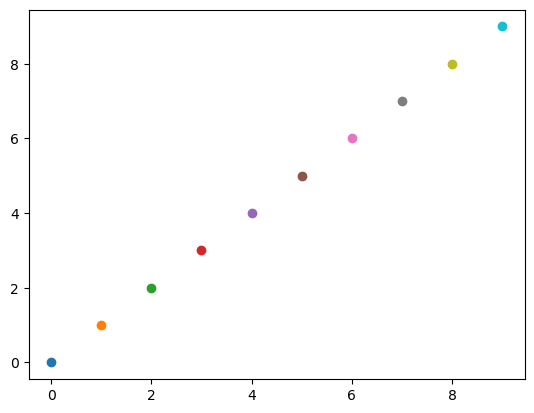

In [51]:
for i  in range(len(colors)):
    plt.plot(i,i,'o',c=colors[i])

In [52]:
def get_area(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

## Figure 1

[0.1, -0.1, 0, 0.1, -0.1, 0, 0.1, -0.1]


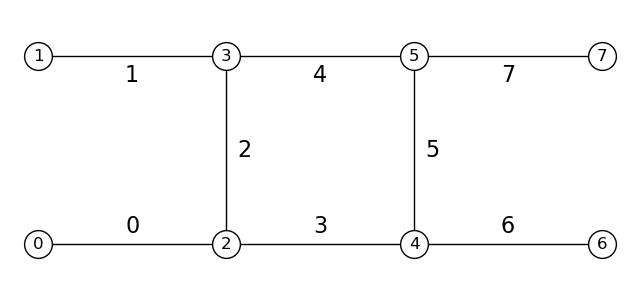

In [53]:
N.v = N.v[:,[1,0]]
N.v[:,0] = 1-N.v[:,0]

annot_offset_x = 8*[0]
annot_offset_y = 8*[0]
for i in range(8):
    if i%3 == 0:
        annot_offset_y[i] = +0.1
    if i%3 == 1:
        annot_offset_y[i] = -0.1
    if i%3 == 2:
        annot_offset_x[i] = 0.1

plt.figure(figsize=(8,4.5))
N.plot(annotate=True,ms=20,annot_offset_x=annot_offset_x,annot_offset_y=annot_offset_y)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylim((-0.25,1.25))
save_fig('network_schematic')

## Figure 2

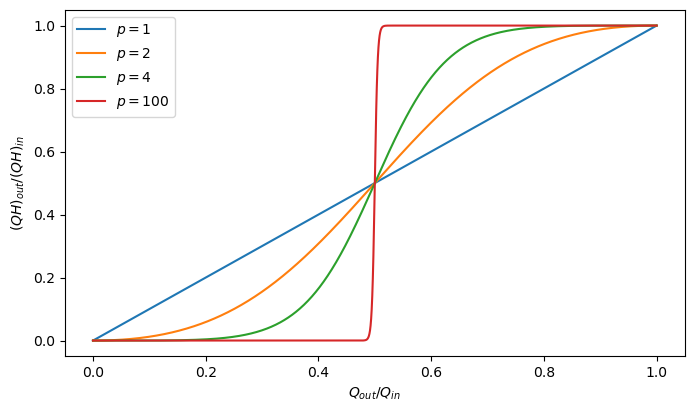

In [54]:
import skimming

plt.figure(figsize=(8,4.5))
q = np.linspace(0,1,1000)
for i,p in enumerate([1,2,4,100]):
    f,g = skimming.skimming_kj(q,p)
    plt.plot(q,f*q,c=colors[i],label=r'$p = $' + f'{p}')
#     plt.plot(q,g*(1-q),'--',c=colors[i],label=None)
    
plt.legend()
plt.xlabel(r'$Q_{out}/Q_{in}$')
plt.ylabel(r'$(QH)_{out}/(QH)_{in}$')
save_fig('skimming')

## Figure 3

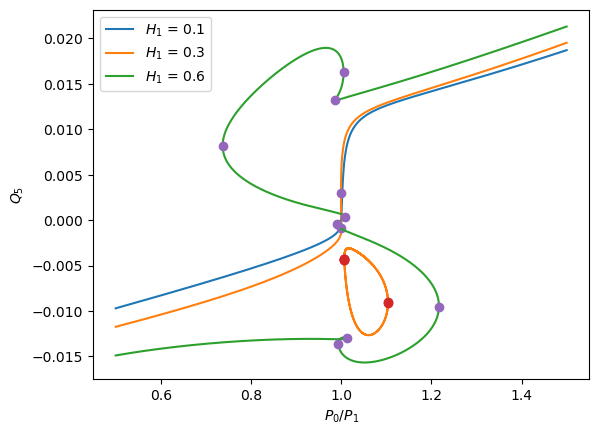

In [55]:
main_branch_continuation = load_data('main_branch_continuation')
isola_continuation = load_data('isola_continuation')

for h1 in main_branch_continuation.keys():
    Q = get_Q(main_branch_continuation[h1])
    plt.plot(Q[:,-1],Q[:,5],label=r'$H_1$ = '+str(h1))
    
    dParam = np.diff(Q[:,-1])
    fold_candidates_idx = np.where(dParam[:-1]*dParam[1:] < 0)[0]
    for idx in fold_candidates_idx:
        plt.plot(Q[idx,-1],Q[idx,5],'o',color=colors[4],label=None)
    
    try:
        Q = Q = get_Q(isola_continuation[h1])
    except:
        continue
    plt.plot(Q[:,-1],Q[:,5],color=colors[1])

    dParam = np.diff(Q[:,-1])
    fold_candidates_idx = np.where(dParam[:-1]*dParam[1:] < 0)[0]
    for idx in fold_candidates_idx:
        plt.plot(Q[idx,-1],Q[idx,5],'o',color=colors[3],label=None)

plt.legend()
plt.xlabel(r'$P_0/P_1$')
plt.ylabel(r'$Q_5$')
save_fig('equilibrium_continuation')

## Figure 4

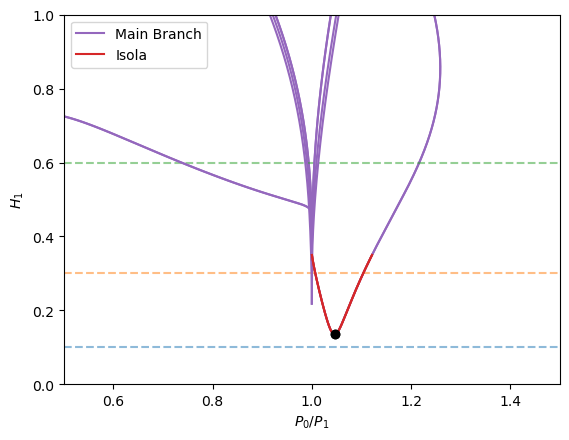

In [56]:
main_branch_continuation = load_data('main_branch_continuation')
folds = load_data('fold_continuation')

main_flag = True
isola_flag = True
for i in folds.keys():
    Y = folds[i]
    
    if np.min(Y[:,-1]) < 0.2:
        idx = np.where(Y[:,-1] < 0.35)[0]
        Y_isola = Y[idx[0]:idx[-1],:]
        if isola_flag:
            isola_label = 'Isola'
            isola_flag = False
        else:
            isola_label = None        
        plt.plot(Y[:,-2],Y[:,-1],label=None,color=colors[4],zorder=-1)        
        plt.plot(Y_isola[:,-2],Y_isola[:,-1],label=isola_label,color=colors[3],zorder=100)
        
        idx = np.argmin(Y[:,-1])        
        plt.plot(Y[idx,-2],Y[idx,-1],'ko',zorder=200)  
    else:
        if main_flag:
            main_label = 'Main Branch'
            main_flag = False
        else:
            main_label = None
        plt.plot(Y[:,-2],Y[:,-1],label=main_label,color=colors[4])
        
for i,level in enumerate(main_branch_continuation.keys()):        
    plt.plot([0.5,1.5],[level, level],'--',color=colors[i],alpha=.5,zorder=-1)        
    
# plt.title('Fold Bifurcation Diagram')
plt.xlabel(r'$P_0/P_1$')
plt.ylabel(r'$H_1$')
plt.xlim((0.5,1.5))
plt.ylim((0,1))
plt.legend()
save_fig('fold_continuation')

## Figure 5

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


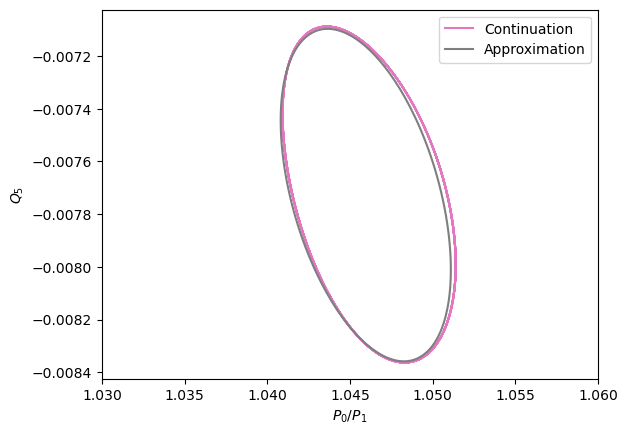

In [57]:
reset_all_network_parameters()

isola_approximation = load_data('isola_approximation')
isola_continuation = load_data('isola_continuation')

vessel_idx = 5
Q = get_Q(isola_continuation[0.14])

plt.plot(Q[:5000,-1],Q[:5000,vessel_idx],color=colors[6],label='Continuation')
plt.plot(isola_approximation[:,-1],isola_approximation[:,N.nNodes+vessel_idx],color=colors[7],label='Approximation')
# plt.title('Numerically Observed Isola vs Theoretical Prediction')
plt.xlabel(r'$P_0/P_1$')
plt.ylabel(r'$Q_' + str(vessel_idx) + '$')
plt.xlim((1.03,1.06))
plt.legend()

save_fig('isola_continuation_vs_approximation')

## Figure 6

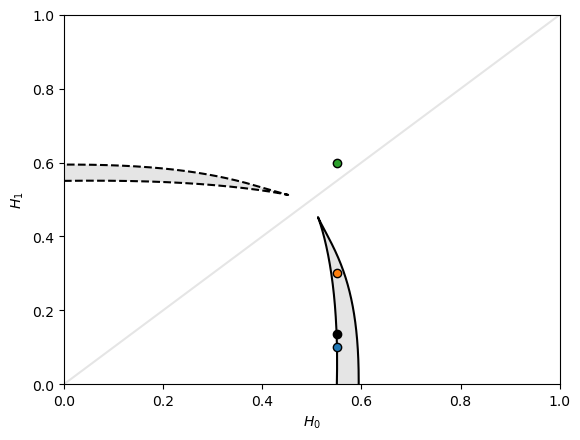

In [58]:
isola_center_continuation = load_data('isola_center_continuation_h0_h1')
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot(0.55,isola_center_init[-1],'ko')
plt.xlabel(r'$H_0$')
plt.ylabel(r'$H_1$')
plt.plot([0,1],[0,1],'k',alpha=0.1)
plt.plot(0.55,0.1,'o',color=colors[0],mec='k')
plt.plot(0.55,0.3,'o',color=colors[1],mec='k')
plt.plot(0.55,0.6,'o',color=colors[2],mec='k')
plt.plot(isola_center_continuation[:,-1],isola_center_continuation[:,-2],'k--')

x = np.append(isola_center_continuation[:,-2],isola_center_continuation[0,-2])
y = np.append(isola_center_continuation[:,-1],isola_center_continuation[0,-1])
plt.fill(x,y,'k',alpha=0.1)
plt.fill(y,x,'k',alpha=0.1)

save_fig('isola_center_continuation_h0_h1')

## Figure 7

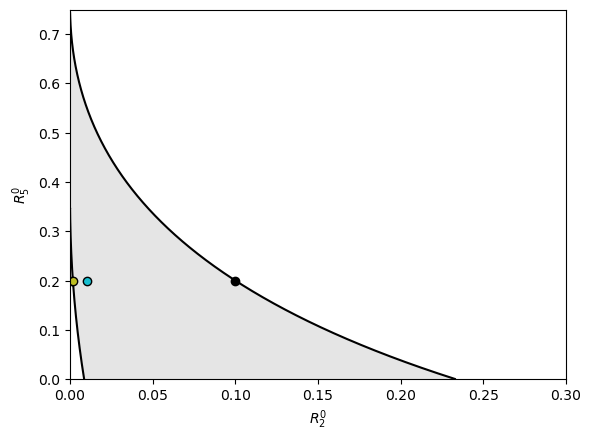

In [59]:
isola_center_continuation = np.real(load_data('isola_center_continuation_r02_r05'))
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k')

x = isola_center_continuation[:1250,-2]
y = isola_center_continuation[:1250,-1]

isola_center_continuation = np.real(load_data('isola_center_continuation_r02_r05_death'))
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k')

x = np.append(x,isola_center_continuation[::-1,-2])
y = np.append(y,isola_center_continuation[::-1,-1])

x = np.append(x,x[0])
y = np.append(y,y[0])

plt.xlabel(r'$R_2^0$')
plt.ylabel(r'$R_5^0$')
plt.plot(0.1,0.2,'ko')
plt.xlim((0,.3))
plt.ylim((0,.75))

plt.fill(x,y,'k',alpha=0.1)
plt.plot(0.01,0.2,'o',c=colors[-1],mec='k')
plt.plot(0.001,0.2,'o',c=colors[-3],mec='k')
plt.plot(0.002,0.2,'o',c=colors[-2],mec='k')


save_fig('isola_center_continuation_r02_r05')

# plt.gca().set_aspect('equal')
# plt.xlim((0.001,0.01))
# plt.ylim((0.001,1))



## Figure 8

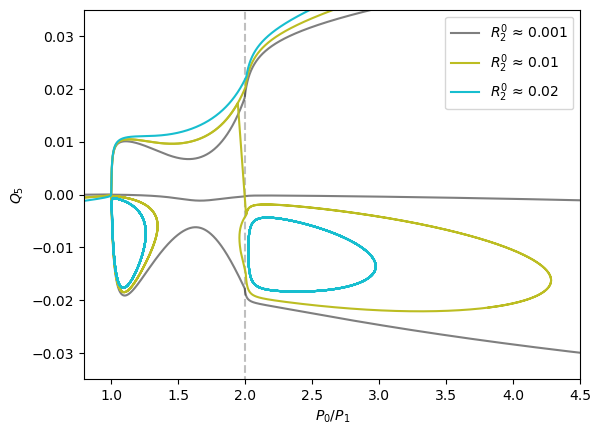

In [60]:
idx0 = -1
idx1 = 5

c = colors
a = [1,1]

for i, r20 in enumerate(main_continuation_merge.keys()):
    N.set_parameter('l',r20,2)
    for j,data in enumerate([main_continuation_merge[r20], other_continuation_merge[r20], isola_continuation_merge[r20]]):
        if i == 1 and j > 0:
            data = data[40000:,:]
        data = get_Q(data)
        label = None
        if j == 0:
            label = r'$R_2^0$' + ' ≈ ' + str(np.round(r20,3))

        if r20 < 0.0018 and j > 1:
            continue

        z = 1
        a = 1
        if r20 < 0.0018:
            z = -1
            a = 1
        plt.plot(data[:,idx0],data[:,idx1],c=c[i+7],alpha=a,label=label,zorder=z)

plt.plot([2,2],[-0.04,0.04],'k--',alpha=0.25,zorder=-1)

plt.legend()
plt.xlabel(r'$P_0/P_1$')
plt.ylabel(r'$Q_' + str(idx1) + '$')

plt.xlim((0.8,4.5))
plt.ylim((-0.035,0.035))
save_fig('isola_coexistence')

## Figure 9

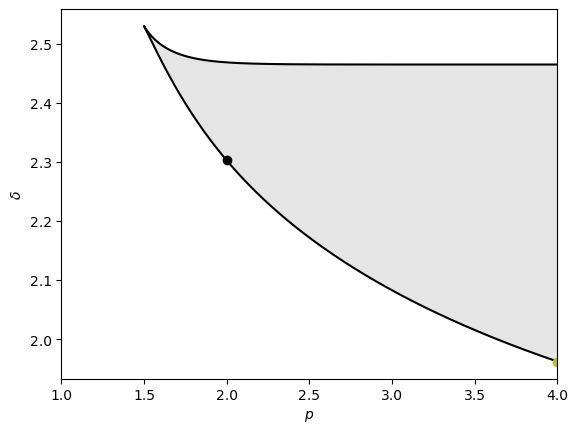

In [61]:
isola_center_continuation = load_data('isola_center_continuation_pPlasma_delta')
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k',label=r'$H_1$ = 0.15')

# isola_center_continuation = load_data('isola_center_continuation_pPlasma_delta_h1_15')
# plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k',label=r'$H_1$ = 0.15')

# isola_center_continuation = load_data('isola_center_continuation_pPlasma_delta_h1_20')
# plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k--',label=r'$H_1$ = 0.20')
plt.xlabel(r'$p$')
plt.ylabel(r'$\delta$')
plt.plot(2,np.log(10),'ko')
plt.plot(4,np.log(7.11),'o',color=colors[8])

x = np.append(isola_center_continuation[:,-2],isola_center_continuation[0,-2])
y = np.append(isola_center_continuation[:,-1],isola_center_continuation[0,-1])
plt.fill(x,y,'k',alpha=0.1)

plt.xlim((1,4))

save_fig('isola_center_continuation_pPlasma_delta')

## Figure 10

Area = 0.0134
Area = 0.0696


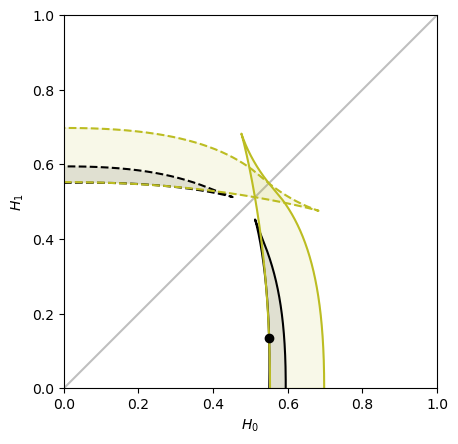

In [62]:
isola_center_continuation = load_data('isola_center_continuation_h0_h1')
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],'k')
plt.plot(isola_center_continuation[:,-1],isola_center_continuation[:,-2],'k--')

x = np.append(isola_center_continuation[:,-2],isola_center_continuation[0,-2])
y = np.append(isola_center_continuation[:,-1],isola_center_continuation[0,-1])
plt.fill(x,y,'k',alpha=0.1)
plt.fill(y,x,'k',alpha=0.1)

print(f'Area = {np.round(get_area(isola_center_continuation[:,-2],isola_center_continuation[:,-1]),4)}')

isola_center_continuation = load_data('isola_center_continuation_h0_h1_p_4')
plt.plot(isola_center_continuation[:,-2],isola_center_continuation[:,-1],color=colors[8])
plt.plot(isola_center_continuation[:,-1],isola_center_continuation[:,-2],'--',color=colors[8])

x = np.append(isola_center_continuation[:,-2],isola_center_continuation[0,-2])
y = np.append(isola_center_continuation[:,-1],isola_center_continuation[0,-1])
plt.fill(x,y,color=colors[8],alpha=0.1)
plt.fill(y,x,color=colors[8],alpha=0.1)

print(f'Area = {np.round(get_area(isola_center_continuation[:,-2],isola_center_continuation[:,-1]),4)}')


plt.plot(0.55,isola_center_init[-1],'ko')
plt.plot([0,1],[0,1],'k',alpha=0.25,zorder=-10)

plt.xlabel(r'$H_0$')
plt.ylabel(r'$H_1$')
plt.xlim((0,1))
plt.ylim((0,1))
plt.gca().set_aspect('equal')

plt.gcf().tight_layout(pad=2)
save_fig('secondary_isola_center_continuation')

## Figure 11

In [63]:
import seaborn as sns

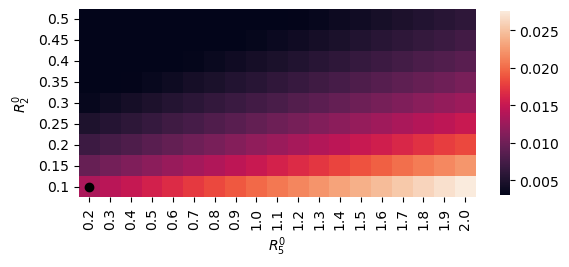

In [64]:
heat_map = load_data('heat_map_r20_r50')
area = heat_map['area']
R20 = heat_map['R20']
R50 = heat_map['R50'][::2]

A = np.zeros((len(R20),len(R50)))
X = np.zeros((len(R20),len(R50)))
for i,r20 in enumerate(R20):
    for j,r50 in enumerate(R50):
        A[i,j] = area[(i,j)]

ax = sns.heatmap(A,vmin=0.003,xticklabels=np.round(R50,2),yticklabels=np.round(R20,2),square=True,cbar_kws={'shrink': 0.5})

ax.invert_yaxis();
plt.xlabel(r'$R_5^0$');
plt.ylabel(r'$R_2^0$');
plt.plot(0.5,0.5,'ko')
save_fig('heat_map_r20_r50')

## Figure 12

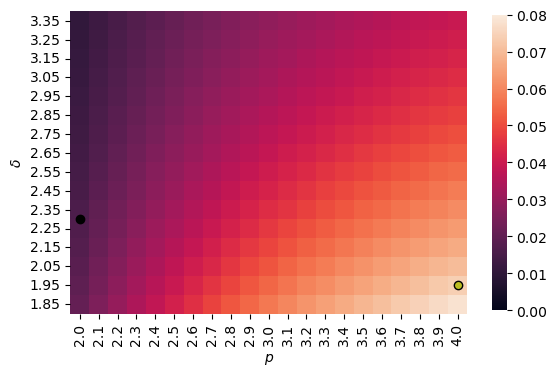

In [65]:
heat_map = load_data('heat_map_p_delta_corrected')
area = heat_map['area']
P = heat_map['P']
Delta = heat_map['Delta'][::2]

A = np.zeros((len(P),len(Delta)))
X = np.zeros((len(P),len(Delta)))
for i,p in enumerate(P):
    for j,delta in enumerate(Delta):
        A[i,j] = area[(i,j)]    

ax = sns.heatmap(A.T,vmin=0,vmax=0.08,xticklabels=np.round(P,2),yticklabels=np.round(Delta,2),square=True,cbar_kws={'shrink':0.8})
#                  cbar_kws={"orientation": "horizontal",'pad':0.2})
ax.invert_yaxis()
plt.xlabel(r'$p$');
plt.ylabel(r'$\delta$');
plt.plot(0.5,5,'ko')
plt.plot(20.5,1.5,'o',color=colors[8],mec='k')
# plt.title(r'Percent of $(H_0,H_1)$ Plane Supporting Isolas')
save_fig('heat_map_p_delta')

## Figure 13

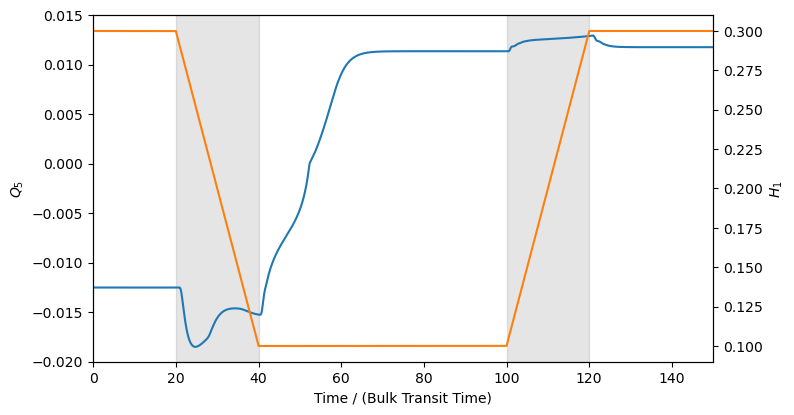

In [66]:
import scipy.io
data = scipy.io.loadmat('data/pdedata_isola_destruction_h1.mat')
Q = data['flowsave']
tau = data['times'].squeeze()

ylim_lo = -0.02
ylim_hi = 0.015

plt.figure(figsize=(8,4.5))

plt.plot(tau,Q[5,:])
plt.xlim(0,150)
plt.fill([20,40,40,20],[ylim_lo,ylim_lo,ylim_hi,ylim_hi],color='k',alpha=0.1)

plt.fill([100,120,120,100],[ylim_lo,ylim_lo,ylim_hi,ylim_hi],color='k',alpha=0.1)
plt.xlabel(r'Time / (Bulk Transit Time)')
plt.ylabel(r'$Q_5$')

plt.ylim((ylim_lo,ylim_hi))

ax2 = plt.gca().twinx()
h1_temp = np.zeros(Q[5,:].shape)

h1_temp += (tau < 20)*0.3
h1_temp += ((tau > 20) & (tau < 40))*(0.5-0.01*tau)
h1_temp += ((tau > 40) & (tau < 100))*0.1
h1_temp += ((tau > 100) & (tau < 120))*(0.01*tau - 0.9)
h1_temp += (tau > 120)*0.3

ax2.plot(tau,h1_temp,c=colors[1])
ax2.set_ylabel(r'$H_1$')

save_fig('isola_destruction_h1')